# Re-implementation of neural tangents cookbook
## Bayesian Inference

In [1]:
import functools
import matplotlib.pyplot as plt
import jax.numpy as np

def format_plot(x=None, y=None):
  # plt.grid(False)
  ax = plt.gca()
  if x is not None:
    plt.xlabel(x, fontsize=20)
  if y is not None:
    plt.ylabel(y, fontsize=20)

def finalize_plot(shape=(1, 1)):
  plt.gcf().set_size_inches(
    shape[0] * 1.5 * plt.gcf().get_size_inches()[1],
    shape[1] * 1.5 * plt.gcf().get_size_inches()[1])
  plt.tight_layout()

def plot_fn(train, test, *fs):
  train_xs, train_ys = train

  plt.plot(train_xs, train_ys, 'ro', markersize=10, label='train')

  if test != None:
    test_xs, test_ys = test
    plt.plot(test_xs, test_ys, 'k--', linewidth=3, label='$f(x)$')

    for f in fs:
      plt.plot(test_xs, f(test_xs), '-', linewidth=3)

  plt.xlim([-np.pi, np.pi])
  plt.ylim([-1.5, 1.5])

  format_plot('$x$', '$f$')
  
legend = functools.partial(plt.legend, fontsize=10)

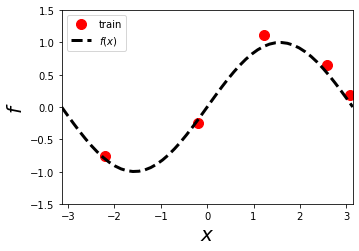

In [2]:
from data_loader import synthetic_dataset
train, test = synthetic_dataset()
train_xs, train_ys = train
test_xs, test_ys = test
plot_fn(train, test)
legend(loc="upper left")
finalize_plot((0.85, 0.6))

In [3]:
from models import FCN
from gpnn import GPNN
fcn = FCN()
gpnn = GPNN(fcn)
prior_draws = gpnn.random_draw(test_xs, 10)

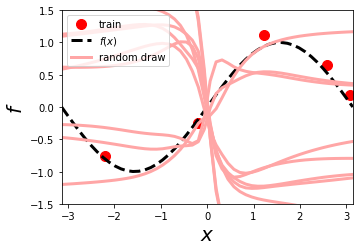

In [4]:
plot_fn(train, test)
for p in prior_draws:
    plt.plot(test_xs, p, linewidth=3, color=[1, 0.65, 0.65])
    
legend(["train", "$f(x)$", "random draw"], loc="upper left")

finalize_plot((0.85, 0.6))

In [5]:
std = gpnn.get_std(test_xs)

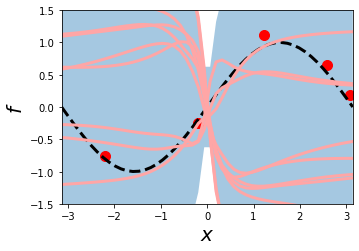

In [6]:
plot_fn(train, test)
plt.fill_between(np.reshape(test_xs, (-1,)), 2 * std, -2 * std, alpha=0.4)
for p in prior_draws:
    plt.plot(test_xs, p, linewidth=3, color=[1, 0.65, 0.65])

finalize_plot((0.85, 0.6))

In [7]:
gpnn.fit(train_xs, train_ys)
nngp_mean, nngp_cov = gpnn.inference(test_xs)
nngp_mean = np.reshape(nngp_mean, (-1,))
nngp_std = np.sqrt(np.diag(nngp_cov))

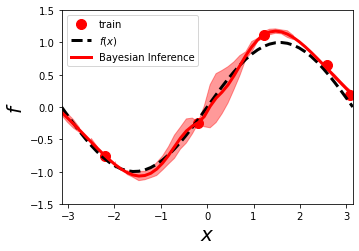

In [8]:
plot_fn(train, test)
plt.plot(test_xs, nngp_mean, 'r-', linewidth=3)
plt.fill_between(np.reshape(test_xs, (-1,)), nngp_mean - 2 * nngp_std, nngp_mean + 2 * nngp_std, color='red', alpha=0.4)

plt.xlim([-np.pi, np.pi])
plt.ylim([-1.5, 1.5])

legend(["train", "$f(x)$", "Bayesian Inference"], loc="upper left")

finalize_plot((0.85, 0.6))

In [9]:
ntk_mean, ntk_cov = gpnn.inference(test_xs, ntk=True)
ntk_mean = np.reshape(ntk_mean, (-1,))
ntk_std = np.sqrt(np.diag(ntk_cov))

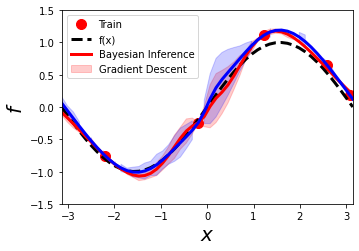

In [10]:
plot_fn(train, test)

plt.plot(test_xs, nngp_mean, 'r-', linewidth=3)
plt.fill_between(
    np.reshape(test_xs, (-1)),
    nngp_mean - 2 * nngp_std,
    nngp_mean +  2 * nngp_std,
    color='red', alpha=0.2)


plt.plot(test_xs, ntk_mean, 'b-', linewidth=3)
plt.fill_between(
    np.reshape(test_xs, (-1)),
    ntk_mean - 2 * ntk_std,
    ntk_mean +  2 * ntk_std,
    color='blue', alpha=0.2)

plt.xlim([-np.pi, np.pi])
plt.ylim([-1.5, 1.5])

legend(['Train', 'f(x)', 'Bayesian Inference', 'Gradient Descent'],
       loc='upper left')

finalize_plot((0.85, 0.6))

In [11]:
from losses import mse_predict

ts = np.arange(0, 10**3, 10**-1) # (10000, )
ntk_train_loss_mean = gpnn.compute_loss(mse_predict, train_ys, ts)
ntk_test_loss_mean = gpnn.compute_loss(mse_predict, test_ys, ts, test_xs)

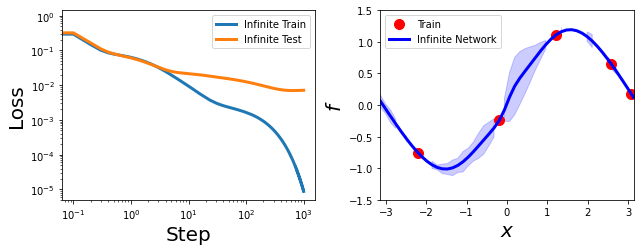

In [12]:
plt.subplot(1, 2, 1)

plt.loglog(ts, ntk_train_loss_mean, linewidth=3)
plt.loglog(ts, ntk_test_loss_mean, linewidth=3)
format_plot('Step', 'Loss')
legend(['Infinite Train', 'Infinite Test'])

plt.subplot(1, 2, 2)

plot_fn(train, None)

plt.plot(test_xs, ntk_mean, 'b-', linewidth=3)
plt.fill_between(
    np.reshape(test_xs, (-1)),
    ntk_mean - 2 * ntk_std,
    ntk_mean +  2 * ntk_std,
    color='blue', alpha=0.2)

legend(
    ['Train', 'Infinite Network'],
    loc='upper left')

finalize_plot((1.5, 0.6))

## Fully Connected Nerual Networks

In [13]:
from nn import Trainer
from losses import mse_loss
from jax.example_libraries import optimizers

training_steps = 10000

optimizer = optimizers.sgd(0.1)
loss = mse_loss(fcn)
trainer = Trainer(fcn, training_steps, optimizer, loss)

opt_params, train_losses, test_losses = trainer.fit(train, test)

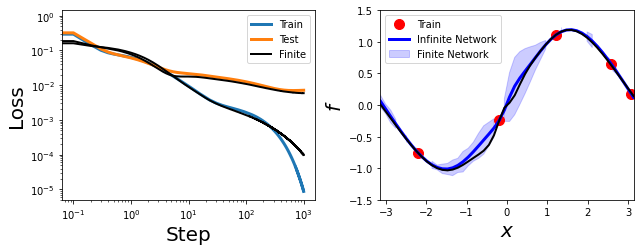

In [14]:
plt.subplot(1, 2, 1)

plt.loglog(ts, ntk_train_loss_mean, linewidth=3)
plt.loglog(ts, ntk_test_loss_mean, linewidth=3)

plt.loglog(ts, train_losses, 'k-', linewidth=2)
plt.loglog(ts, test_losses, 'k-', linewidth=2)

format_plot('Step', 'Loss')
legend(['Train', 'Test', 'Finite'])

plt.subplot(1, 2, 2)

plot_fn(train, None)

plt.plot(test_xs, ntk_mean, 'b-', linewidth=3)
plt.fill_between(
    np.reshape(test_xs, (-1)),
    ntk_mean - 2 * ntk_std,
    ntk_mean +  2 * ntk_std,
    color='blue', alpha=0.2)

plt.plot(test_xs, fcn.apply_fn(opt_params, test_xs), 'k-', linewidth=2)

legend(['Train', 'Infinite Network', 'Finite Network'], loc='upper left')

finalize_plot((1.5, 0.6))

In [15]:
params, train_loss, test_loss = trainer.ensemble_fit(train, test, 1)

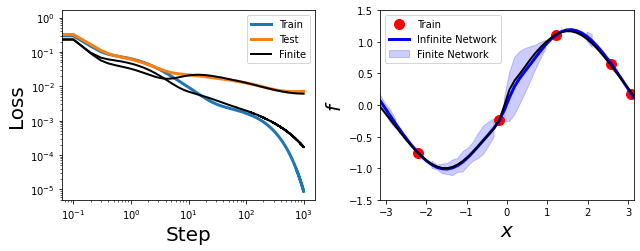

In [16]:
plt.subplot(1, 2, 1)

plt.loglog(ts, ntk_train_loss_mean, linewidth=3)
plt.loglog(ts, ntk_test_loss_mean, linewidth=3)

plt.loglog(ts, train_loss, 'k-', linewidth=2)
plt.loglog(ts, test_loss, 'k-', linewidth=2)

format_plot('Step', 'Loss')
legend(['Train', 'Test', 'Finite'])

plt.subplot(1, 2, 2)

plot_fn(train, None)

plt.plot(test_xs, ntk_mean, 'b-', linewidth=3)
plt.fill_between(
    np.reshape(test_xs, (-1)),
    ntk_mean - 2 * ntk_std,
    ntk_mean +  2 * ntk_std,
    color='blue', alpha=0.2)

plt.plot(test_xs, fcn.apply_fn(params, test_xs), 'k-', linewidth=2)

legend(['Train', 'Infinite Network', 'Finite Network'], loc='upper left')

finalize_plot((1.5, 0.6))

In [17]:
opt_params, train_loss, test_loss = trainer.ensemble_fit(train, test, 100)

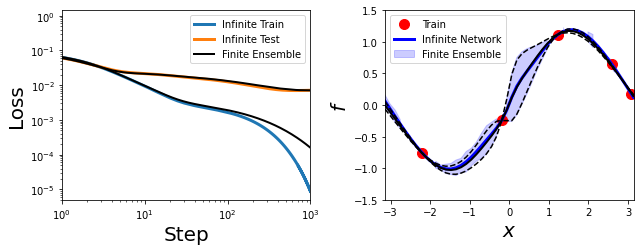

In [18]:
from jax import vmap

plt.subplot(1, 2, 1)

mean_train_loss = np.mean(train_loss, axis=0)
mean_test_loss = np.mean(test_loss, axis=0)

plt.loglog(ts, ntk_train_loss_mean, linewidth=3)
plt.loglog(ts, ntk_test_loss_mean, linewidth=3)

plt.loglog(ts, mean_train_loss, 'k-', linewidth=2)
plt.loglog(ts, mean_test_loss, 'k-', linewidth=2)

plt.xlim([10 ** 0, 10 ** 3])

plt.xscale('log')
plt.yscale('log')
format_plot('Step', 'Loss')

legend(['Infinite Train', 'Infinite Test', 'Finite Ensemble'])

plt.subplot(1, 2, 2)

plot_fn(train, None)

plt.plot(test_xs, ntk_mean, 'b-', linewidth=3)
plt.fill_between(
    np.reshape(test_xs, (-1)),
    ntk_mean - 2 * ntk_std,
    ntk_mean +  2 * ntk_std,
    color='blue', alpha=0.2)

ensemble_fx = vmap(fcn.apply_fn, (0, None))(opt_params, test_xs)

mean_fx = np.reshape(np.mean(ensemble_fx, axis=0), (-1,))
std_fx = np.reshape(np.std(ensemble_fx, axis=0), (-1,))

plt.plot(test_xs, mean_fx - 2 * std_fx, 'k--', label='_nolegend_')
plt.plot(test_xs, mean_fx + 2 * std_fx, 'k--', label='_nolegend_')
plt.plot(test_xs, mean_fx, linewidth=2, color='black')

legend(['Train', 'Infinite Network', 'Finite Ensemble'], loc='upper left')

plt.xlim([-np.pi, np.pi])
plt.ylim([-1.5, 1.5])

format_plot('$x$', '$f$')
finalize_plot((1.5, 0.6))

## Residual

In [23]:
from models import ResFCN
from util import split_key

training_steps = 10000
ensemble_size = 100
learning_rate = 0.1
ts = np.arange(0, 10 ** 3, learning_rate)

resfcn = ResFCN()
loss = mse_loss(resfcn)
optimizer = optimizers.sgd(learning_rate)
trainer = Trainer(resfcn, training_steps, optimizer, loss)

key, = split_key(1)
params, train_loss, test_loss = trainer.ensemble_fit(train, test, ensemble_size)

In [24]:
gpnn = GPNN(resfcn)
gpnn.fit(train_xs, train_ys)
ntk_mean, ntk_cov = gpnn.inference(test_xs, ntk=True)

ntk_mean = np.reshape(ntk_mean, (-1,))
ntk_std = np.sqrt(np.diag(ntk_cov))

ntk_train_loss_mean = gpnn.compute_loss(mse_predict, train_ys, ts)
ntk_test_loss_mean = gpnn.compute_loss(mse_predict, test_ys, ts, test_xs)

/home/ycniu/anaconda3/envs/ic-project/lib/python3.8/site-packages/neural_tangents/_src/stax/branching.py:395: UserWarning: `FanIn` layers assume independent inputs which is not verified in the code. Please make sure to have at least one `Dense` / `Conv` / `GlobalSelfAttention` etc. layer in each branch.
  warnings.warn('`FanIn` layers assume independent inputs which is not verified'


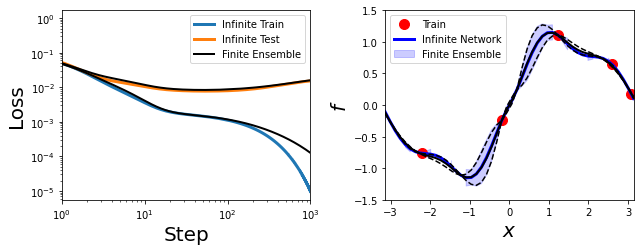

In [25]:
plt.subplot(1, 2, 1)

mean_train_loss = np.mean(train_loss, axis=0)
mean_test_loss = np.mean(test_loss, axis=0)

plt.loglog(ts, ntk_train_loss_mean, linewidth=3)
plt.loglog(ts, ntk_test_loss_mean, linewidth=3)

plt.loglog(ts, mean_train_loss, 'k-', linewidth=2)
plt.loglog(ts, mean_test_loss, 'k-', linewidth=2)

plt.xlim([10 ** 0, 10 ** 3])

plt.xscale('log')
plt.yscale('log')
format_plot('Step', 'Loss')

legend(['Infinite Train', 'Infinite Test', 'Finite Ensemble'])

plt.subplot(1, 2, 2)

plot_fn(train, None)

plt.plot(test_xs, ntk_mean, 'b-', linewidth=3)
plt.fill_between(
    np.reshape(test_xs, (-1)),
    ntk_mean - 2 * ntk_std,
    ntk_mean +  2 * ntk_std,
    color='blue', alpha=0.2)

ensemble_fx = vmap(resfcn.apply_fn, (0, None))(params, test_xs)

mean_fx = np.reshape(np.mean(ensemble_fx, axis=0), (-1,))
std_fx = np.reshape(np.std(ensemble_fx, axis=0), (-1,))

plt.plot(test_xs, mean_fx - 2 * std_fx, 'k--', label='_nolegend_')
plt.plot(test_xs, mean_fx + 2 * std_fx, 'k--', label='_nolegend_')
plt.plot(test_xs, mean_fx, linewidth=2, color='black')

legend(['Train', 'Infinite Network', 'Finite Ensemble'], loc='upper left')

plt.xlim([-np.pi, np.pi])
plt.ylim([-1.5, 1.5])

format_plot('$x$', '$f$')
finalize_plot((1.5, 0.6))
